<a href="https://colab.research.google.com/github/hajonghyun/installPytorch_study/blob/main/4_torch_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import torch

In [95]:
import numpy as np
import matplotlib.pyplot as plt


# Binary Classification

## STEP 1. 데이터 모으기

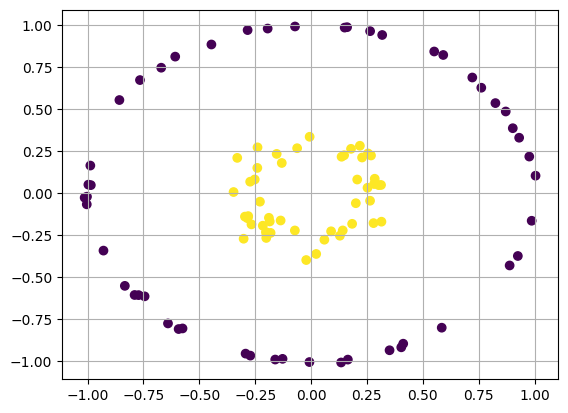

In [96]:
# case 1
# N=20
# random0=torch.randn(int(N/2),1)
# random5=torch.randn(int(N/2),1)+5
# class1_data=torch.hstack([random0,random5])  # 0,5 근처 값들?
# class2_data=torch.hstack([random5,random0])  # 5,0 근처 값들?
# class1_label=torch.ones(int(N/2),1)
# class2_label=torch.zeros(int(N/2),1)
# x=torch.vstack([class1_data,class2_data])
# y=torch.vstack([class1_label,class2_label])

# case 2
N=100
radius1=0.3+0.05*torch.randn(int(N/2),1)
radius2=1+0.01*torch.randn(int(N/2),1)
theta1=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
theta2=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
class1_data=torch.hstack([radius1*torch.cos(theta1),radius1*torch.sin(theta1)])
class2_data=torch.hstack([radius2*torch.cos(theta2),radius2*torch.sin(theta2)])
class1_label=torch.ones(int(N/2),1)
class2_label=torch.zeros(int(N/2),1)
x=torch.vstack([class1_data,class2_data])
y=torch.vstack([class1_label,class2_label])



plt.figure()
plt.scatter(x[:,0],x[:,1],c=y)
plt.grid()

## STEP 2. 모델 만들기

In [97]:
from torch import nn

In [98]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # case1, plain
        # self.linear=nn.Sequential(nn.Linear(2,10000), # 10, 100, 1000으로 바꿔보면서 확인
        #                            nn.Sigmoid(),
        #                            nn.Linear(10000,1), # node가 많을수록 좋게 나옴
        #                            nn.Sigmoid())

        # case 1, very simple
        # self.linear = nn.Sequential(nn.Linear(2,1),
        #                             nn.Sigmoid())

        # case1, deep
        self.linear = nn.Sequential(nn.Linear(2,100),
                                    nn.Sigmoid(),
                                    nn.Linear(100,100),
                                    nn.Sigmoid(),
                                    nn.Linear(100,100),
                                    nn.Sigmoid(),
                                    nn.Linear(100,1),
                                    nn.Sigmoid()
                                    )

    def forward(self,x):
        x=self.linear(x)
        return x





In [99]:
# 랜덤값으로 출력값 체크 (학습 전)
example=torch.randn(5,2)
model=MLP()
print(model)
print(model(example))

MLP(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
tensor([[0.4740],
        [0.4735],
        [0.4734],
        [0.4738],
        [0.4734]], grad_fn=<SigmoidBackward0>)


## STEP 3. 모델 학습시키기

In [100]:
from torch import optim
# !pip install torchviz
# from torchviz import make_dot

In [101]:
LR=1e-1    # case1
# LR=1e-2  # case2, plain에서 노드 1000개, deep
# LP=1e-4  # case2, very deep relu

EPOCH=100
# EPOCH=500


# optimizer=optim.SGD(model.parameters(),lr=LR)
optimizer=optim.Adam(model.parameters(),lr=LR)

criterion=nn.BCELoss() # Binary Cross Entropy

loss_history=[]
# grad_history=[]
# update_size_history=[]

model.train()
for ep in range(EPOCH):
    # 예측 -> loss -> 미분 -> 업데이트 flow
    y_hat=model(x) # 1. Inference 로 예측하고
    loss=criterion(y_hat,y) # 2. Loss 구해서
    optimizer.zero_grad()
    loss.backward() # 3. BackPropagation 미분하고
    optimizer.step() # 4. Weight Update 업데이트한다.
    loss_history.append(loss.item())
    # print(f"Epoch: {ep+1}, train loss: {loss.item():.4f}")
    # print("=====================")

In [102]:
# Binary Cross Entropy 수식으로 확인해보기
print(criterion(y_hat,y))
print(torch.sum(-torch.log(y_hat**y * (1-y_hat)**(1-y)))/N)

# 무한대로 발산은 100이 최대다. (clamping)
print(criterion(torch.tensor([0.]), torch.tensor([1.])))

tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6931, grad_fn=<DivBackward0>)
tensor(100.)


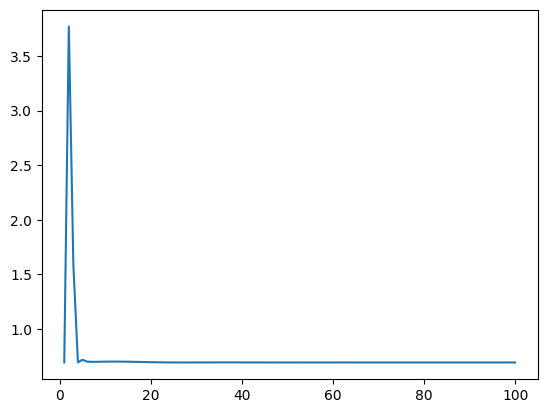

In [103]:
plt.plot(range(1,EPOCH+1),loss_history) #????

## STEP 4. 모델 테스트하기

Text(0.5, 0.5, 'x2')

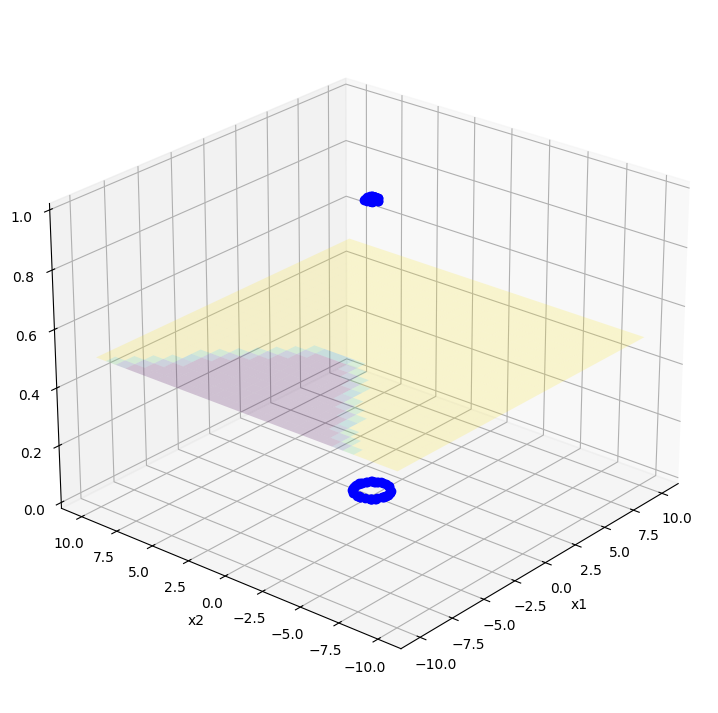

In [104]:
# 모델 테스트

x1_test=torch.linspace(-10,10,30)
x2_test=torch.linspace(-10,10,30)

x1_test,x2_test=torch.meshgrid(x1_test,x2_test)

x_test=torch.cat([x1_test.unsqueeze(dim=2),x2_test.unsqueeze(dim=2)],dim=2)

model.eval() # 1. test mode
# 1. dropout 혹은 Batch Norm 같은거 사용했다면 train mode 와 test mode 동작이 다르므로 eval()로 mode를 바꿔줘야함.

with torch.no_grad(): # 2. grad_fn 계산 끔 <- 메모리가 불필요하게 쓰인다.
    y_hat=model(x_test)

y_hat=y_hat.squeeze()


plt.figure(figsize=[10,9])
ax = plt.axes(projection='3d')
ax.view_init(elev=25,azim=-140)

ax.plot_surface(x1_test,x2_test,y_hat.numpy(),cmap='viridis',alpha=0.2)
plt.plot(class1_data[:,0],class1_data[:,1],class1_label.squeeze(),'bo')
plt.plot(class2_data[:,0],class2_data[:,1],class2_label.squeeze(),'bo')
plt.xlabel('x1')
plt.ylabel('x2')

In [105]:
# # Regression 연습 예제


# import torch
# from torch import nn
# from torch import optim


# torch.manual_seed(42) # 결과 고정

# # 입력: 집의 크기, 방 개수, 연식 (Feature 3개)
# x = torch.randn(100, 3)
# # 정답: 실제 집값 (우리가 찾아야 할 규칙: 5x_1 - 2x_2 + x_3 + 10)
# true_weights = torch.tensor([[5.0], [-2.0], [1.0]])
# true_bias = 10.0
# # y = x * w + b + noise
# y = x @ true_weights + true_bias + torch.randn(100, 1) * 0.1
# print(f"데이터 준비 완료! x: {x.shape}, y: {y.shape}")
# print("-" * 30)
# # ==========================================

In [106]:
# # Regression 연습 예제

# #0. 클래스 정의

# class myModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.myfc=nn.Sequential(nn.Linear(3,5),
#                                 nn.ReLU(),
#                                 nn.Linear(5,10),
#                                 nn.ReLU(),
#                                 nn.Linear(10,1),
#                                 )

#     def forward(self,x):
#         x=self.myfc(x)
#         return x

# #1. 모델 정의
# model = myModel()

# #2.
# LR = 1e-2
# EPOCH = 100
# criterion = nn.MSELoss()
# optimizer = optim.Adam(params=model.parameters(),lr=LR)
# loss_history = []

# for ep in range(EPOCH):
#     # inference
#     y_hat = model(x)
#     # loss
#     loss = criterion(y_hat,y)
#     # grad 초기화
#     optimizer.zero_grad()
#     # BackPropagation
#     loss.backward()
#     # Update
#     optimizer.step()

#     print(f"Epoch: {ep+1}, Loss : {loss.item():.4f}")
#     print("============")




